In [27]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import dill as pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import torch
import nibabel as nb

import nctpy

from tqdm.notebook import tqdm

DATA7_PATH = "/System/Volumes/Data/data/data7"
projects_path = f"{DATA7_PATH}/network_control/projects"
sys.path.insert(1, projects_path)
import CAP_tools


NC_path = f"{DATA7_PATH}/network_control/projects/network_control"
sys.path.insert(1, NC_path)
import plot
import surface_mapping as sfm

import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
N_PARCELS = 400
data_types = ["rfMRI_REST1_7T_PA", "tfMRI_MOVIE_7T_DAY_1"]
data_exts = ["_hp2000_clean_nilearn", "_hp2000_clean_nilearn_ISCH"]

In [29]:
_, fMRI_parcellation, _, subject_list = load.load_constants(N_PARCELS)
tf_arrays, template_cifti = load.load_ptseries(subject_list, data_types,
                                               data_exts, fMRI_parcellation)

rfMRI_all, tfMRI_all = tf_arrays["rfMRI_all"], tf_arrays["tfMRI_all"]
ROI_labels, network_labels = load.load_labels(template_cifti)

Loading ptseries:   0%|          | 0/174 [00:00<?, ?it/s]

### Load CAPs

In [33]:
CAP_analysis_label = "tfMRI_MOVIE_7T_DAY_1"
isc = 0
K = 12

CAP_pkl_path = load.get_CAP_pkl_path(CAP_analysis_label, K, isc=isc)
CAP_states, CAP_labels, n_CAPs = load.load_CAPs(CAP_pkl_path, subject_list, tfMRI_all)

# State Correlation between Subjects

In [ ]:
ntfMRI_all =  (tfMRI_all / np.sum(tfMRI_all ** 2, axis=2, keepdims=True))

MA = np.array([[np.sqrt(np.sum((ntfMRI_all[i] - ntfMRI_all[j]) ** 2, axis=1))
                for i in range(174)] for j in range(174)])

MA_mean = np.clip(MA.mean(axis=2) - .13, 0, 0.045)
M = np.abs(np.corrcoef(ntfMRI_all.reshape(174, -1)))
M = (M + M.T) / 2
M[np.diag_indices_from(M)] = 1

M = np.array([[(CAP_labels[i] == CAP_labels[j]).mean() for i in range(174)] for j in range(174)])

In [ ]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

DF_dism = 1 / np.clip(M, 0.04, 1) - 1
# DF_dism = MA_mean

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=plt.cm.Reds)

# Bold Velocity Points

In [19]:
def znorm(x, axis=None):
    return (x - np.mean(x, axis=axis, keepdims=True)) / np.std(x, axis=axis, keepdims=True)

(-3.0, 5.0)

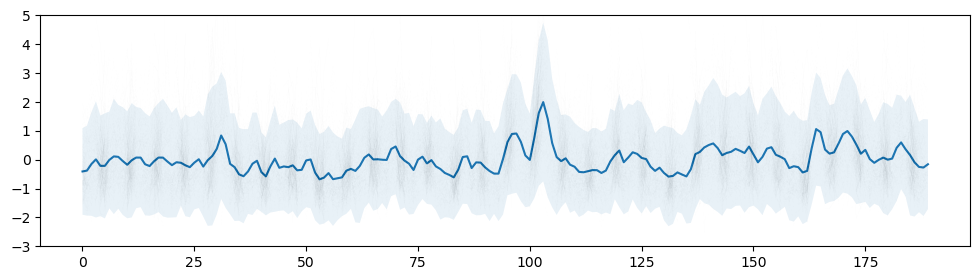

In [20]:
BOLD_velocity = np.sqrt(np.sum(np.gradient(tfMRI_all, axis=1) ** 2, axis=2))
BOLD_accel = np.sqrt(np.sum(np.gradient(np.gradient(tfMRI_all, axis=1), axis=1) ** 2, axis=2))
n_sm = 1
BV_sm = np.array([np.convolve(bv, np.ones(n_sm)/n_sm, mode = "valid") for bv in BOLD_velocity])
BV_sm = znorm(BV_sm, axis=1)

n_crop = 10
clip_change_inds = np.where(np.mean(BV_sm, axis=0) > 1)[0]
clip_change_inds = np.hstack([np.arange(max(ci - n_crop, 0), min(ci + n_crop, len(BV_sm[0])))
                                       for ci in clip_change_inds])
clip_change_inds = np.sort(np.unique(clip_change_inds))
clip_change_inds = np.hstack([np.arange(10), np.arange(200, len(BV_sm[0]))])
crop_inds = np.isin(np.arange(len(BV_sm[0])), clip_change_inds)


BV_sm = BV_sm[:, ~crop_inds]
BV_sm = znorm(BV_sm, axis=1)

trs = np.arange(len(BV_sm[0]))
fig, ax = plt.subplots(figsize=(12, 3))
m = np.mean(BV_sm, axis=0)
s = np.std(BV_sm, axis=0)
ax.plot(m)
ax.plot(trs, BV_sm.T, linewidth=0.001, color="k");
ax.fill_between(trs, m - 1.96 * s, m + 1.96 * s, alpha=0.1)
ax.set_ylim(-3, 5)

<Axes: ylabel='Density'>

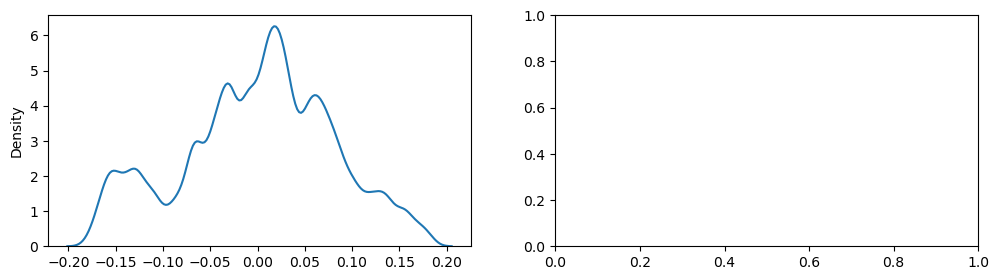

In [24]:
r_s = []
for i in range(400):
    # for j in range(len(BV_sm)):
    #     r, p = scipy.stats.pearsonr(BV_sm[j], tfMRI_all[j, ~crop_inds, i])
    #     r_s.append(r)
    r, p = scipy.stats.pearsonr(BV_sm.ravel(), tfMRI_all[:, ~crop_inds, i].ravel())
    # r, p = scipy.stats.pearsonr(m.ravel(), np.mean(tfMRI_all[:, ~crop_inds, i], axis=0).ravel())
    r_s.append(r)

fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 3))
sns.kdeplot(r_s, bw_method=0.1, ax=a0)